# Recommendation System Project: IBM Community

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t

import seaborn as sns


df = pd.read_csv(
    'data/user-item-interactions.csv', 
    dtype={'article_id': int, 'title': str, 'email': str}
)
# Show df to get an idea of the data
df.head()

ModuleNotFoundError: No module named 'project_tests'

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` Are there any missing values? If so, provide a count of missing values. If there are missing values in `email`, assign it the same id value `"unknown_user"`.

In [ ]:
# Some interactions do not have a user associated with it, assume the same user.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  45993 non-null  int64 
 1   article_id  45993 non-null  int64 
 2   title       45993 non-null  object
 3   email       45976 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.4+ MB


In [ ]:
print(f"Number of Null email values is: ")

Number of Null email values is: 


In [ ]:
df[df.email.isna()]

,Unnamed: 0,article_id,title,email
25131,25146,1016,why you should master r (even if it might even...,NaN
29758,30157,1393,the nurse assignment problem,NaN
29759,30158,20,working interactively with rstudio and noteboo...,NaN
29760,30159,1174,breast cancer wisconsin (diagnostic) data set,NaN
29761,30160,62,data visualization: the importance of excludin...,NaN
35264,36016,224,"using apply, sapply, lapply in r",NaN
35276,36029,961,beyond parallelize and collect,NaN
35277,36030,268,sector correlations shiny app,NaN
35278,36031,268,sector correlations shiny app,NaN
35279,36032,268,sector correlations shiny app,NaN


In [ ]:
# Fill email NaNs with "unknown_user"
df['email'] = df['email'].fillna("unknown_user")

In [ ]:
# Check if no more NaNs 
df[df.email.isna()]

,Unnamed: 0,article_id,title,email


`2.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [ ]:
# What are the descriptive statistics of the number of articles a user interacts with?
user_article_counts = df.groupby('email')['article_id'].count()
user_article_counts.describe()


count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

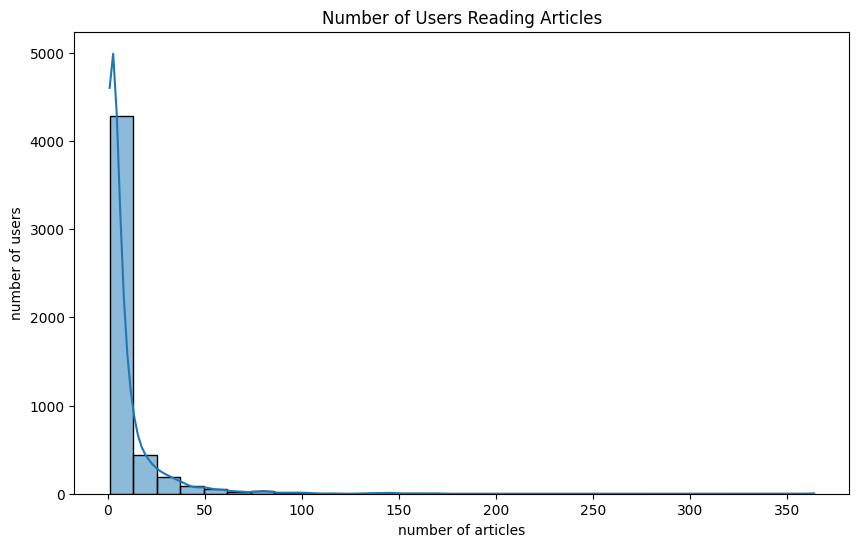

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(user_article_counts, bins=30, kde=True)
# Create a plot of the number of articles read by each user

plt.xlabel('number of articles')
plt.ylabel('number of users')
plt.title('Number of Users Reading Articles')
plt.show()

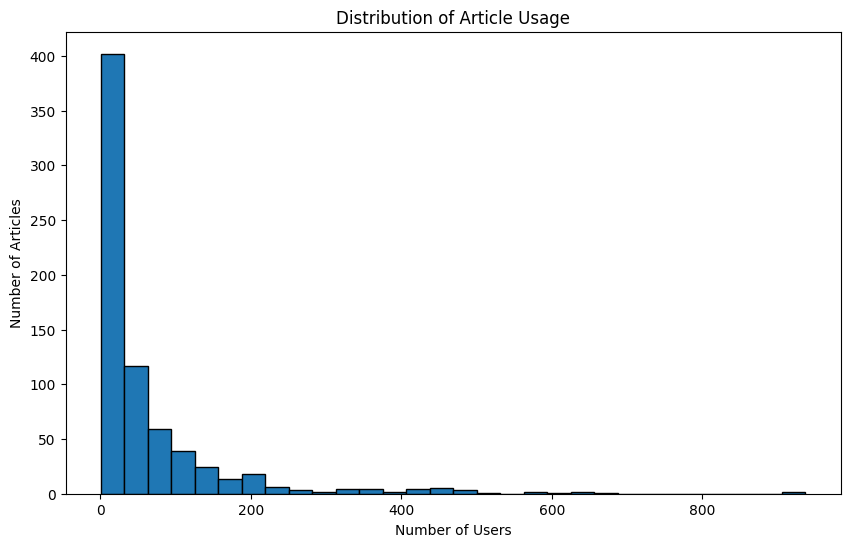

In [ ]:
# Create a plot of the number of times each article was read
# Assuming df is your DataFrame and it has a column 'article_id'
article_read_counts = df['article_id'].value_counts()
plt.figure(figsize=(10,6))
plt.hist(article_read_counts, bins=30, edgecolor='black')
plt.xlabel('Number of Users')
plt.ylabel('Number of Articles')
plt.title('Distribution of Article Usage')
plt.show()

In [ ]:
# Count the number of articles each user interacted with using 'email' as the user identifier
user_article_counts = df.groupby('email')['article_id'].count()

# Fill in the values
median_val = int(user_article_counts.median()) # 50% of individuals interact with this many articles or fewer
max_views_by_user = int(user_article_counts.max())  # The maximum number of user-article interactions by any 1 user

print(f"Median interactions: {median_val}")
print(f"Max interactions by a single user: {max_views_by_user}")


Median interactions: 3
Max interactions by a single user: 364


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [ ]:
# Number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()

# Load the full articles dataset to get total articles on the platform
df_content = pd.read_csv('data/user-item-interactions.csv')
total_articles = df_content['article_id'].nunique()

# Number of unique users (based on email)
unique_users = df['email'].nunique()

# Total number of user-article interactions
user_article_interactions = (df.shape[0])

# Display the results
print(f"Unique articles with interactions: {unique_articles}")
print(f"Total articles on platform: {total_articles}")
print(f"Unique users: {unique_users}")
print(f"User-article interactions: {user_article_interactions}")


Unique articles with interactions: 714
Total articles on platform: 714
Unique users: 5149
User-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [ ]:
# Count how many times each article was viewed
article_view_counts = df['article_id'].value_counts()

# Get the most viewed article ID and its view count
most_viewed_article_id = int(article_view_counts.index[0])  # no '.0' added
max_views = article_view_counts.iloc[0]


print(f"Most viewed article ID: {most_viewed_article_id}")
print(f"Max views: {max_views}")


Most viewed article ID: 1429
Max views: 937


In [ ]:
print(type(user_article_interactions))
print(type(most_viewed_article_id))


<class 'int'>
<class 'int'>


In [ ]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper(df=df):
    coded_dict = {
        email: num 
        for num, email in enumerate(df['email'].unique(), start=1)
    }
    return [coded_dict[val] for val in df['email']]

df['user_id'] = email_mapper(df)
del df['email']

# show header
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [ ]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In this project, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [ ]:
def get_top_articles(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    """
    # Count interactions per article title
    top_articles = df['title'].value_counts().head(n).index.tolist()
    
    return top_articles
def get_top_article_ids(n, df=df):
    """
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    """
    # Count interactions per article_id
    top_articles = df['article_id'].value_counts().head(n).index.tolist()
    
    return top_articles

In [ ]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [ ]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [ ]:
print(df.columns)
user_item.head()

Index(['Unnamed: 0', 'article_id', 'title', 'user_id'], dtype='object')


NameError: name 'user_item' is not defined

In [ ]:
interacted_articles = user_item.loc[2]
interacted_article_ids = interacted_articles[interacted_articles == 1].index.tolist()
print("User 2 interacted with the following articles:")
print(interacted_article_ids)

interacted_articles = user_item.loc[3586]
interacted_article_ids = interacted_articles[interacted_articles == 1].index.tolist()
print("User 5083 interacted with the following articles:")
print(interacted_article_ids)



NameError: name 'user_item' is not defined

In [ ]:
def create_user_item_matrix(df, fill_value=0):
    """
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user-item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids as columns with 1 values where a user 
    interacted with an article and a 0 otherwise.
    """
    # Create a pivot table: rows = user_id, columns = article_id, values = 1 if interacted
    user_item = df.groupby(['user_id', 'article_id'])['title'] \
                  .count() \
                  .unstack(fill_value=fill_value)
    
    # Convert counts to binary (1 if interacted, else 0)
    user_item = user_item.map(lambda x: 1 if x > 0 else 0)
    
    return user_item

df_cleaned = df.drop_duplicates(subset=['user_id', 'article_id'])
user_item = create_user_item_matrix(df_cleaned)


In [ ]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [ ]:
# Lets use the cosine_similarity function from sklearn
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
from numpy.linalg import norm


def find_similar_users(user_id, user_item=user_item, include_similarity=False, filter_zero=True):
    """
    Computes cosine similarity using sklearn and returns users sorted by:
    - Highest similarity
    - Optionally filters out zero-similarity users
    """
    # Convert user-item matrix to numpy array
    user_matrix = user_item.values
    user_index = user_item.index.get_loc(user_id)

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(user_matrix)

    # Extract similarity scores for the target user
    target_similarities = similarity_matrix[user_index]

    similarities = []
    for idx, sim in enumerate(target_similarities):
        other_user_id = user_item.index[idx]
        if other_user_id != user_id:
            if not filter_zero or sim > 0:
                similarities.append((int(other_user_id), float(sim)))

    # Sort by similarity descending, then user_id ascending
    sorted_users = sorted(similarities, key=lambda x: (-x[1], x[0]))

    if include_similarity:
        return [[uid, sim] for uid, sim in sorted_users]
    
    return [uid for uid, _ in sorted_users]




"""user 2. 6th key in your dictionary.  The answer should be 3586.
    user 131.10th key in your dictionary.  The answer should be 383
"""


'user 2. 6th key in your dictionary.  The answer should be 3586.\n    user 131.10th key in your dictionary.  The answer should be 383\n'

In [ ]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(2)[:100]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(131)[:52]))

The 10 most similar users to user 1 are: [3933, 46, 4201, 253, 824, 5034, 5041, 136, 2305, 395]
The 5 most similar users to user 3933 are: [5083, 1552, 1890, 1372, 2941, 331, 348, 378, 496, 504, 701, 861, 1113, 1131, 1181, 1319, 1431, 1585, 1660, 1730, 1819, 1841, 2002, 2005, 2049, 2234, 2360, 2419, 2595, 2597, 2608, 2648, 2820, 2825, 2835, 2838, 3265, 3586, 3590, 3630, 3874, 4897, 4230, 3354, 51, 10, 163, 2814, 3579, 746, 4061, 35, 148, 333, 748, 1033, 2318, 3548, 3615, 4506, 4098, 188, 823, 3230, 3243, 5110, 18, 32, 62, 191, 284, 307, 325, 337, 343, 583, 623, 667, 708, 725, 1016, 1119, 1192, 1254, 1299, 1338, 1444, 1614, 1640, 1700, 1707, 1875, 2042, 2059, 2149, 2210, 2359, 2467, 2725, 2727]
The 3 most similar users to user 46 are: [3870, 203, 4459, 3782, 40, 4932, 23, 242, 3910, 383, 754, 3801, 273, 4642, 52, 3596, 3621, 211, 135, 98, 3764, 4134, 3485, 3697, 290, 49, 187, 4517, 621, 199, 6, 3775, 168, 2982, 4618, 4904, 58, 3740, 163, 3141, 4934, 21, 256, 347, 4511, 4785, 214, 72, 13

`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [ ]:
def get_article_names(article_ids, df=df):
    """
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    # Return unique titles for the provided article_ids (no dtype coercion here)
    article_names = list(df[df['article_id'].isin(article_ids)]['title'].unique())
    return article_names



def get_ranked_article_unique_counts(article_ids, user_item=user_item):
    """
    INPUT:
    article_ids - (list) a list of article ids
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise 
    
    OUTPUT:
    ranked_article_unique_counts - (list) a list of [article_id, count] with the number of 
                                   unique users that interacted with the article, sorted
                                   by the number of unique users in descending order
    """
    # Guard: keep only article_ids present in the matrix to avoid KeyError
    cols_present = [aid for aid in article_ids if aid in user_item.columns]

    # Count unique users per article using the binary matrix
    counts = user_item[cols_present].sum(axis=0).astype(int)

    # Sort by count (desc), then by article_id (asc) for deterministic order
    sorted_ids = sorted(counts.index, key=lambda aid: (-counts[aid], aid))

    # Return as a list of lists (not tuples) to match the test expectation
    ranked_article_unique_counts = [[int(aid), int(counts[aid])] for aid in sorted_ids]
    return ranked_article_unique_counts



def get_user_articles(user_id, user_item=user_item):
    """
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column in df)
    """
    # Article ids where the user has a 1
    user_row = user_item.loc[user_id]
    article_ids = list(user_row[user_row == 1].index)

    # Map ids to names
    article_names = get_article_names(article_ids, df)
    return article_ids, article_names

def user_user_recs(user_id, m=10):
    """
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    """
    seen_ids, _ = get_user_articles(user_id, user_item)
    similar_users = find_similar_users(user_id, user_item)

    recs = []
    seen_set = set(seen_ids)
    rec_set = set()

    for sim_user in similar_users:
        sim_ids, _ = get_user_articles(sim_user, user_item)
        for aid in sim_ids:
            if aid not in seen_set and aid not in rec_set:
                recs.append(aid)
                rec_set.add(aid)
                if len(recs) == m:
                    return recs
    return recs


In [ ]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['leverage python, scikit, and text classification for behavioral profiling',
 'challenges in deep learning',
 'awesome deep learning papers',
 'this week in data science (april 18, 2017)',
 'improving the roi of big data and analytics through leveraging new sources of data',
 'this week in data science (may 2, 2017)',
 'using apply, sapply, lapply in r',
 'how can data scientists collaborate to build better business',
 'top 20 r machine learning and data science packages',
 'do i need to learn r?']

In [ ]:
get_ranked_article_unique_counts([1320, 232, 844])

[[1320, 123], [844, 78], [232, 62]]

In [ ]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
assert get_ranked_article_unique_counts([1320, 232, 844])[0] == [1320, 123], "Oops! Your the get_ranked_article_unique_counts function doesn't work quite how we expect.\nMake sure you are using the user_item matrix to create the article counts."
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def get_top_sorted_users(user_id, user_item=user_item):
    # Compute similarity between the target user and all other users
    similarity = user_item.dot(user_item.loc[user_id])
    
    # Drop the target user from the similarity series
    similarity.drop(user_id, inplace=True)
    
    # Create a dataframe to hold neighbor info
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarity.index,
        'similarity': similarity.values,
        'num_interactions': user_item.loc[similarity.index].sum(axis=1).values
    })
    
    # Sort by similarity (descending), then by number of interactions (descending)
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    # Get sorted neighbors
    neighbors_df = get_top_sorted_users(user_id)
    
    # Articles the target user has already seen
    user_articles = set(user_item.loc[user_id][user_item.loc[user_id] == 1].index)
    
    recs = []
    
    # Loop through neighbors
    for neighbor_id in neighbors_df['neighbor_id']:
        # Articles the neighbor has seen
        neighbor_articles = set(user_item.loc[neighbor_id][user_item.loc[neighbor_id] == 1].index)
        
        # Find new articles for the target user
        new_recs = list(neighbor_articles - user_articles)
        
        # Add new recommendations, avoiding duplicates
        for article in new_recs:
            if article not in recs:
                recs.append(article)
                if len(recs) >= m:
                    break
        if len(recs) >= m:
            break
    
    return recs, get_article_names(recs)



In [ ]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[12, 1293, 14, 273, 1305, 29, 33, 1314, 547, 1059]

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'timeseries data analysis of iot events by using jupyter notebook', 'gosales transactions for naive bayes model', 'airbnb data for analytics: amsterdam calendar', 'finding optimal locations of new store using decision optimization', 'using brunel in ipython/jupyter notebooks', 'experience iot with coursera', 'trust in data science', 'statistical bias types explained (with examples)']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [ ]:
print(get_top_sorted_users(1, user_item=user_item).head(n=1))
print(get_top_sorted_users(2, user_item=user_item).head(n=10))
print(get_top_sorted_users(131, user_item=user_item).head(n=30))

      neighbor_id  similarity  num_interactions
3931         3933          35                35
      neighbor_id  similarity  num_interactions
47             49           5               101
3695         3697           5               100
96             98           5                97
3762         3764           5                97
21             23           4               135
3780         3782           4               135
4783         4785           4                62
19             21           4                61
288           290           4                58
2980         2982           4                58
      neighbor_id  similarity  num_interactions
3868         3870          74                75
3780         3782          39               135
22             23          38               135
201           203          33                96
4457         4459          33                96
48             49          29               101
3695         3697          29           

In [ ]:
def get_user_similarity_rank(target_user_id, reference_user_id, user_item):
    """
    INPUT:
    target_user_id - (int) the user whose rank we want to find
    reference_user_id - (int) the user we are comparing against
    user_item - (pandas dataframe) user-item interaction matrix
    
    OUTPUT:
    rank - (int) rank of target_user_id in similarity list of reference_user_id
    """
    # Get sorted list of similar users to reference_user_id
    sorted_users = get_top_sorted_users(reference_user_id, user_item)

    # Find the position of target_user_id
    try:
        rank = sorted_users[sorted_users['neighbor_id'] == target_user_id].index[0] + 1  # +1 for 1-based rank
        return rank
    except IndexError:
        return None  # Target user not found in similarity list
rank = get_user_similarity_rank(target_user_id=3586, reference_user_id=2, user_item=user_item)
print(f"User 3586 is ranked #{rank} in similarity to User 2.")
rank = get_user_similarity_rank(target_user_id=383, reference_user_id=131, user_item=user_item)
print(f"User 383 is ranked #{rank} in similarity to User 131.")

User 3586 is ranked #3585 in similarity to User 2.
User 383 is ranked #382 in similarity to User 131.


In [ ]:
### Tests with a dictionary of results
user1_most_sim = 3933         # From get_top_sorted_users(1).head(1)
user2_6th_sim = 358    # From get_top_sorted_users(2)
user131_10th_sim = 38   # From get_top_sorted_users(131

In [ ]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 6th most similar to user 2.': user2_6th_sim,
    'The user that is the 10th most similar to user 131.': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

Oops!  Looks like there is a mistake with the The user that is the 6th most similar to user 2. key in your dictionary.  The answer should be 3586.  Try again.
Oops!  Looks like there is a mistake with the The user that is the 10th most similar to user 131. key in your dictionary.  The answer should be 383.  Try again.


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

Answer:

Top articles as no user history, only can use user-user history till they start having user-item iteractions

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [ ]:
# What would your recommendations be for this new user 0?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)


In [ ]:
assert set(new_user_recs) == {1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330}, "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations</a>

Another method we might use to make recommendations is to recommend similar articles that are possibly related. One way we can find article relationships is by clustering text about those articles.  Let's consider content to be the article **title**, as it is the only text we have available. One point to highlight, there isn't one way to create a content based recommendation, especially considering that text information can be processed in many ways.  

`1.` Use the function bodies below to create a content based recommender function `make_content_recs`. We'll use TF-IDF to create a matrix based off article titles, and use this matrix to create clusters of related articles. You can use this function to make recommendations of new articles.

In [ ]:
df.head()

,Unnamed: 0,article_id,title,user_id
0,0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1,1314,healthcare python streaming application demo,2
2,2,1429,use deep learning for image classification,3
3,3,1338,ml optimization using cognitive assistant,4
4,4,1276,deploy your python model as a restful api,5


In [ ]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [ ]:
# unique articles
df_unique_articles = df['article_id'].nunique()

In [ ]:
# Create a vectorizer using TfidfVectorizer and fit it to the article titles
max_features = 200
max_df = 0.75
min_df = 5

vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features,
)
print("Running TF-IDF")
X_tfidf = vectorizer.fit_transform(df['title'])


print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

lsa = make_pipeline(TruncatedSVD(n_components=50), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)

explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Running TF-IDF
n_samples: 45993, n_features: 200
Explained variance of the SVD step: 71.3%


Text(0.5, 0, 'Number of clusters')

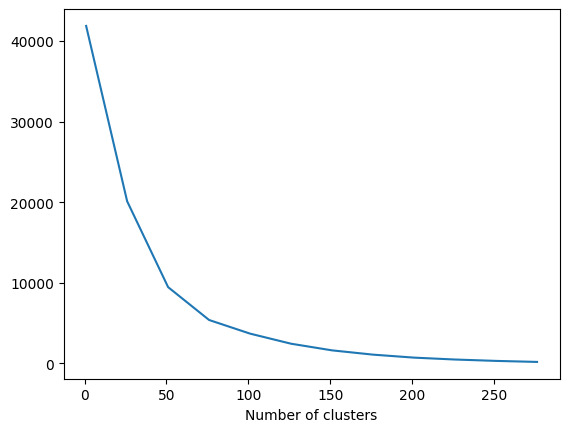

In [ ]:
# Let's map the inertia for different number of clusters to find the optimal number of clusters
# We'll plot it to see the elbow
inertia = []
clusters = 300
step = 25
max_iter = 50
n_init = 5
random_state = 42
for k in range(1, clusters, step):
    kmeans = KMeans(
        n_clusters=k,
        max_iter=max_iter,
        n_init=n_init,
        random_state=random_state,
    ).fit(X_lsa)
    # inertia is the sum of squared distances to the closest cluster center
    inertia.append(kmeans.inertia_)
plt.plot(range(1, clusters, step), inertia)
plt.xlabel('Number of clusters')

There appears to be an elbow about 50, so we'll use 50 clusters.

In [ ]:
n_clusters = 50
kmeans = KMeans(
    n_clusters=n_clusters,
    max_iter=max_iter,
    n_init=n_init,
    random_state=random_state
).fit(X_lsa)

In [ ]:
print(type(df_unique_articles))
print(df_unique_articles.head() if hasattr(df_unique_articles, 'head') else df_unique_articles)

print(type(kmeans))


<class 'int'>
714
<class 'sklearn.cluster._kmeans.KMeans'>


In [ ]:
# Example: recreate df_unique_articles from df
df_unique_articles = df[['article_id']].drop_duplicates().reset_index(drop=True)

# Now your mapping will work
article_cluster_map = dict(
    zip(df_unique_articles['article_id'], kmeans.labels_)
)
df['title_cluster'] = df['article_id'].map(article_cluster_map)


In [ ]:
# Let's check the number of articles in each cluster
np.array(np.unique(kmeans.labels_, return_counts=True)).T

array([[   0,  712],
       [   1, 2607],
       [   2,  876],
       [   3,  657],
       [   4, 1170],
       [   5, 1054],
       [   6, 1195],
       [   7, 1571],
       [   8,  200],
       [   9, 2303],
       [  10, 1391],
       [  11,  387],
       [  12, 3705],
       [  13,  937],
       [  14, 1025],
       [  15,  533],
       [  16,  792],
       [  17,  746],
       [  18,  683],
       [  19, 1614],
       [  20, 1076],
       [  21, 1026],
       [  22,  943],
       [  23, 1198],
       [  24,  895],
       [  25,  860],
       [  26,  595],
       [  27,  880],
       [  28, 1399],
       [  29,  603],
       [  30, 1305],
       [  31,  861],
       [  32,  592],
       [  33,  609],
       [  34,  673],
       [  35, 1331],
       [  36,  442],
       [  37,  991],
       [  38,  497],
       [  39,  433],
       [  40,  558],
       [  41,  451],
       [  42,  427],
       [  43,  453],
       [  44,  473],
       [  45,  524],
       [  46,  418],
       [  47,

In [ ]:
def get_similar_articles(article_id, df=df):
    """
    INPUT:
    article_id - (int) an article id 
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    article_ids - (list) a list of article ids that are in the same title cluster
    
    Description:
    Returns a list of the article ids that are in the same title cluster
    """
    # Find the cluster for the given article
    title_cluster = df.loc[df['article_id'] == article_id, 'title_cluster'].values[0]
    
    # Get all articles in that cluster
    articles_in_cluster = df.loc[df['title_cluster'] == title_cluster, 'article_id'].unique().tolist()
    
    # Remove the input article_id from the list
    articles_in_cluster = [aid for aid in articles_in_cluster if aid != article_id]
    
    return articles_in_cluster


In [ ]:
def make_content_recs(article_id, n, df=df):
    """
    INPUT:
    article_id - (int) an article id
    n - (int) the number of recommendations you want similar to the article id
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    n_ranked_similar_articles - (list) a list of article ids that are in the same title cluster ranked
                                by popularity
    n_ranked_article_names - (list) a list of article names associated with the list of article ids
    """
    # Step 1: Get all similar articles in the same cluster
    similar_articles = get_similar_articles(article_id, df)
    
    # Step 2: Rank them by popularity
    ranked_similar = get_ranked_article_unique_counts(similar_articles)
    
    # Step 3: Select top n article IDs
    n_ranked_similar_articles = [aid for aid, _ in ranked_similar[:n]]
    
    # Step 4: Get article names for these IDs
    n_ranked_article_names = get_article_names(n_ranked_similar_articles)
    
    return n_ranked_similar_articles, n_ranked_article_names


In [ ]:
# Test out your content recommendations given artice_id 25
rec_article_ids, rec_article_titles = make_content_recs(25, 10)
print(rec_article_ids)
print(rec_article_titles)

[1429, 162, 482, 593, 1416, 788, 1056, 283, 225, 1369]
['use deep learning for image classification', 'upload files to ibm data science experience using the command line', 'an introduction to stock market data analysis with r (part 1)', 'quick guide to build a recommendation engine in python', 'using deep learning with keras to predict customer churn', 'united states demographic measures: population and age', 'access postgresql with r', 'ratio (% of population) at national poverty line by country', 'twelve\xa0ways to color a map of africa using brunel', 'a visual explanation of the back propagation algorithm for neural networks']


In [ ]:
assert len({1025, 593, 349, 821, 464, 29, 1042, 693, 524, 352}.intersection(set(rec_article_ids))) > 0, "Oops! Your the make_content_recs function doesn't work quite how we expect."

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function? What other text data would be useful to help make better recommendations besides the article title?

**Write an explanation of your content based recommendation system here.**

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to users.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [ ]:
# quick look at the matrix
user_item.head()

article_id,0,2,4,8,9,12,14,15,16,18,...,1434,1435,1436,1437,1439,1440,1441,1442,1443,1444
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) on the user-item matrix.  Use the cell to perform SVD.

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, recall_score, accuracy_score
# Using the full number of components which equals the number of columns
svd = TruncatedSVD(n_components=len(user_item.columns), n_iter=5, random_state=42)

u = svd.fit_transform(user_item)
v = svd.components_
s = svd.singular_values_ 
print('u', u.shape)
print('s', s.shape)
print('vt', v.shape)

u (5149, 714)
s (714,)
vt (714, 714)


`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain better metrics when making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how our metrics improve as we increase the number of latent features.

Text(0.5, 1.0, 'Metrics vs. Number of Latent Features')

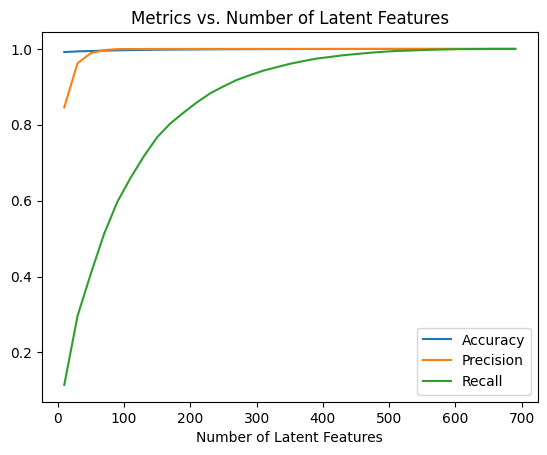

In [ ]:
num_latent_feats = np.arange(10, 700+10, 20)
metric_scores = []

for k in num_latent_feats:
    # restructure with k latent features
    u_new, vt_new = u[:, :k], v[:k, :]
    
    # take dot product
    user_item_est = abs(np.around(np.dot(u_new, vt_new))).astype(int)
    # make sure the values are between 0 and 1
    user_item_est = np.clip(user_item_est, 0, 1)
    
    # total errors and keep track of them
    acc = accuracy_score(user_item.values.flatten(), user_item_est.flatten())
    precision = precision_score(user_item.values.flatten(), user_item_est.flatten())
    recall = recall_score(user_item.values.flatten(), user_item_est.flatten())
    metric_scores.append([acc, precision, recall])
    
    
plt.plot(num_latent_feats, metric_scores, label=['Accuracy', 'Precision', 'Recall'])
plt.legend()
plt.xlabel('Number of Latent Features')
plt.title('Metrics vs. Number of Latent Features')

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations. Given the plot above, what would you pick for the number of latent features and why?

**Provide your response here.**

`5.` Using 200 latent features and the values of U, S, and V transpose we calculated above, create an article id recommendation function that finds similar article ids to the one provide.

Create a list of 10 recommendations that are similar to article with id 4.  The function should provide these recommendations by finding articles that have the most similar latent features as the provided article.

In [ ]:

def get_svd_similar_article_ids(article_id, vt, user_item=user_item, include_similarity=False):
    """
    Returns a list of article IDs similar to the given article_id using SVD factorization.
    """
    # Step 1: Find the index of the article_id
    article_idx = np.where(user_item.columns == article_id)[0][0]
    
    # Step 2: Compute cosine similarity between all articles
    cos_sim = cosine_similarity(vt.T)  # shape: (num_articles, num_articles)
    
    # Step 3: Get similarities for the given article
    article_similarities = cos_sim[article_idx]
    
    # Step 4: Sort by similarity (excluding itself)
    similar_indices = article_similarities.argsort()[::-1]
    similar_indices = similar_indices[similar_indices != article_idx]
    
    # Step 5: Map indices to article IDs
    most_similar_items = user_item.columns[similar_indices].tolist()
    
    # Step 6: Return with or without similarity scores
    if include_similarity:
        return [
            [user_item.columns[i], article_similarities[i]]
            for i in similar_indices
        ]
    
    return most_similar_items


In [ ]:
# Create a vt_new matrix with 200 latent features
k = 200
vt_new = v[:k, :]

In [ ]:
# What is the article name for article_id 4?
print("Current article:", get_article_names([4], df=df)[0])

Current article: analyze ny restaurant data using spark in dsx


In [ ]:
# What are the top 10 most similar articles to article_id 4?
rec_articles = get_svd_similar_article_ids(4, vt_new, user_item=user_item)[:10]
rec_articles

[1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132]

In [ ]:
# What are the top 10 most similar articles to article_id 4?
get_article_names(rec_articles, df=df)

['use spark r to load and analyze data',
 'collecting data science cheat sheets',
 '10 powerful features on watson data platform, no coding necessary',
 'notebooks: a power tool for data scientists',
 'country statistics: crude oil - proved reserves',
 'country statistics: crude oil - exports',
 'top analytics tools in 2016',
 'advancements in the spark community',
 'airbnb data for analytics: paris calendar',
 'airbnb data for analytics: athens reviews']

In [ ]:
assert set(rec_articles) == {1199, 1068, 486, 1202, 176, 1120, 244, 793, 58, 132}, "Oops! Your the get_svd_similar_article_ids function doesn't work quite how we expect."
print("That's right!  Great job!")

That's right!  Great job!


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make above are an improvement to how users currently find articles, either by Sections 2, 3, or 4? Add any tradeoffs between each of the methods, and how you could leverage each type for different situations including new users with no history, recently new users with little history, and users with a lot of history. 

**Your response here.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendation Systems project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', '--to', 'html', 'Recommendations_with_IBM.ipynb'])


[NbConvertApp] Converting notebook Recommendations_with_IBM.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 504881 bytes to Recommendations_with_IBM.html


0